In [254]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [255]:
df = pd.read_csv('Data/USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.8+ KB


In [256]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [257]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [258]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [259]:
pca = PCA(n_components=None)
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [260]:
pca_loadings = pd.DataFrame(pca.components_.T, 
                            index=df.columns,
                            columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_loadings

               PC1       PC2       PC3       PC4
Murder   -0.535899  0.418181 -0.341233  0.649228
Assault  -0.583184  0.187986 -0.268148 -0.743407
UrbanPop -0.278191 -0.872806 -0.378016  0.133878
Rape     -0.543432 -0.167319  0.817778  0.089024

In [261]:
df_plot = pd.concat([(X*pca_loadings.PC1).sum(axis=1),(X*pca_loadings.PC2).sum(axis=1)], axis=1, keys=['PC1', 'PC2'])
df_plot.head()

                 PC1       PC2
Alabama    -0.985566  1.133392
Alaska     -1.950138  1.073213
Arizona    -1.763164 -0.745957
Arkansas    0.141420  1.119797
California -2.523980 -1.542934

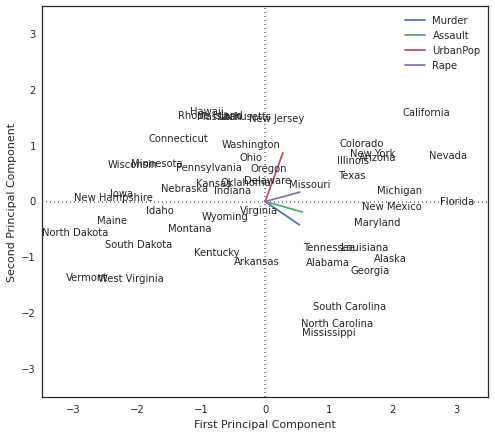

In [305]:
plt.figure(figsize=(8,7))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)

for i in df_plot.index:
    plt.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

plt.plot([0,-pca_loadings.PC1[0]], [0,-pca_loadings.PC2[0]], label='Murder')    
plt.plot([0,-pca_loadings.PC1[1]], [0,-pca_loadings.PC2[1]], label='Assault')  
plt.plot([0,-pca_loadings.PC1[2]], [0,-pca_loadings.PC2[2]], label='UrbanPop')  
plt.plot([0,-pca_loadings.PC1[3]], [0,-pca_loadings.PC2[3]], label='Rape')  
plt.legend()

plt.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
plt.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [265]:
pca.explained_variance_

array([ 2.48024158,  0.98976515,  0.35656318,  0.17343009])

In [266]:
pca.explained_variance_ratio_

array([ 0.62006039,  0.24744129,  0.0891408 ,  0.04335752])

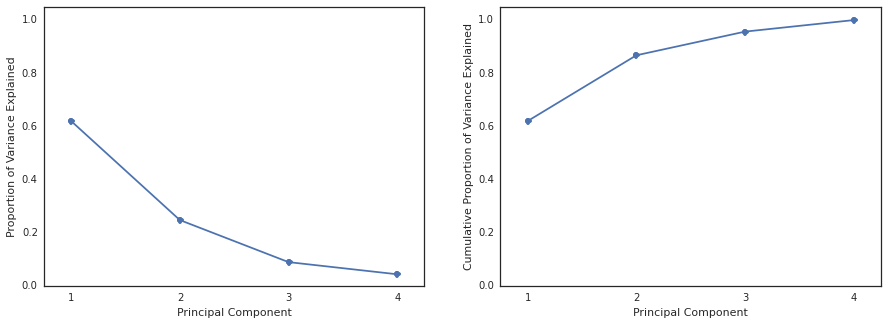

In [298]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot([1,2,3,4], pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')

ax2.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-o')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(0.75,4.25)
    ax.set_ylim(0,1.05)
    ax.set_xticks([1,2,3,4])